In [1]:
import torch
import torch.nn as nn

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [2]:
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size = 3),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_c, out_c, kernel_size = 3),
        nn.ReLU(inplace = True)
    )
    return conv

def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[:, :, delta:tensor_size - delta, delta:tensor_size - delta]

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()   # При наследовании классов
        
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.down_conv_1 = double_conv(1, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)
        
        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels = 1024, 
            out_channels = 512,
            kernel_size = 2, 
            stride = 2)
        self.up_conv_1 = double_conv(1024, 512)
        
        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels = 512, 
            out_channels = 256,
            kernel_size = 2, 
            stride = 2)
        self.up_conv_2 = double_conv(512, 256)
        
        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels = 256, 
            out_channels = 128,
            kernel_size = 2, 
            stride = 2)
        self.up_conv_3 = double_conv(256, 128)
        
        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels = 128, 
            out_channels = 64,
            kernel_size = 2, 
            stride = 2)
        self.up_conv_4 = double_conv(128, 64)
        
        self.out = nn.Conv2d(
            in_channels = 64,
            out_channels = 3,
            kernel_size = 1)
        
    def forward(self, image):
        # encoder
        x1 = self.down_conv_1(image)  # ---->
        #print(x1.size())
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2) # ---->
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4) # ---->
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6) # ---->
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)
        #print(x9.size())
        
        # decoder
        x = self.up_trans_1(x9)
        y = crop_img(x7, x)
        x = self.up_conv_1(torch.cat([x, y], 1))
        
        x = self.up_trans_2(x)
        y = crop_img(x5, x)
        x = self.up_conv_2(torch.cat([x, y], 1))
        
        x = self.up_trans_3(x)
        y = crop_img(x3, x)
        x = self.up_conv_3(torch.cat([x, y], 1))
        
        x = self.up_trans_4(x)
        y = crop_img(x1, x)
        x = self.up_conv_4(torch.cat([x, y], 1))
        
        x = self.out(x)
        #print(x.size())
        return x

In [3]:
# loadind model
PATH = 'UNet_model.pt'
UNet_model = UNet()
UNet_model.load_state_dict(torch.load(PATH))
UNet_model.eval()

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_5): Sequential(
    (0): Conv2d(512, 1024, kernel_

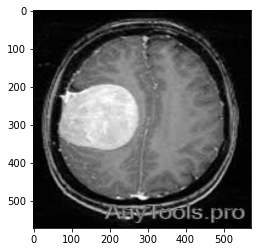

In [6]:
# Testing for model
i = 2
name_part = 'yes'        
# Загрузка изображения
s = 'images/brain_tumor_dataset/' + str(name_part) + '/1 (' + str(i) + ').jpg'
img = cv.imread(s,0) 

#cv2.imshow('Color blue',color_image[:,:,0])
#cv2.imshow('Color green',color_image[:,:,1])
#cv2.imshow('Color red',color_image[:,:,2])

x_new = 572
y_new = 572
dsize = (x_new, y_new)
output = cv.resize(img, dsize, interpolation = cv.INTER_AREA)
output = torch.tensor([[output.T]]).float()
mean = output.mean()
max_ = output.max()
output_ = (output - mean) / max_
plt.imshow(output_[0][0].T, cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


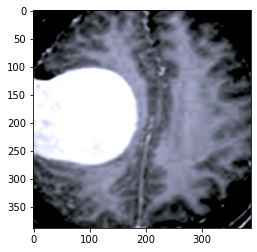

In [7]:
j = 0
y = UNet_model(output_[j:j+1,:1,:572,:572])
img = y.detach().numpy() * 12
IMG = img[0].T

plt.subplots(figsize = (4,4))
plt.imshow(IMG)
plt.show()